In [235]:
from tqdm import tqdm

import numpy as np
import pandas as pd
import re

from collections import Counter
from collections import defaultdict
from scipy import sparse
from scipy.stats import uniform

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Part 1: Representing Text Data

In [236]:
train = pd.read_csv("train.csv")
train.head()

,party_affiliation,email_text,uid_email
0,Democratic Party,⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱⋱...,3083493a6b205eabd8d0f1e7772db09b
1,Democratic Party,This new report needs your attention now. \n ...,3a583e28c820e1fac8902e4df0ef50e0
2,Democratic Party,<PARTY> <ORG> <ORG> <ORG> \n <> NEWS \n <PERS...,044219f46cca419d1d95242dfe036c15
3,Democratic Party,Chip in today to <GPE> to our virtual grassroo...,68059dd1d93d0cbf456763822d1ab680
4,Democratic Party,I ’m really sorry to bother you but I ’m not o...,9f41a878e2839dc013546e615da83efa


In [237]:
dev = pd.read_csv("dev.csv")
dev.head()

,party_affiliation,email_text,uid_email
0,Democratic Party,"<> <>, \n <DATE>, <> <PERSON> <PERSON> suspend...",64241625785edfde727dd84c08e5cda2
1,Democratic Party,We simply could not run our campaign without o...,d005af10b61a2565704c237fd506b5e9
2,Democratic Party,I have to give <> <> <PERSON> and the team an ...,75088c6211cca345172d18aab778b93c
3,Democratic Party,"Here ’s your challenge: Can we raise $ 10,000 ...",b56badd20bd35485b7197587333283d1
4,Democratic Party,"This week, I and more than 30 of my colleagues...",f60dc5576465f00970e35e36e57e9f1e


In [238]:
test = pd.read_csv("test.csv")
test.head()

,email_text,uid_email
0,"20,000 <GPE> <GPE> signatures needed \n 20,000...",5dfbe09ce5b500dd3dcb9f93c8fb185f
1,We 've worked way too hard and given way too m...,07e48f4183b98420a18503791fb412f6
2,If you use your 800%-MATCH \n <> \n <ORG> <OR...,b58c8607d96a414db0e9cc10108c35f5
3,"<PERSON>, a proposal for Vote- by- <> threaten...",3901d9539d69ada89e5c82e2f1ca950d
4,The <ORG> <ORG> <ORG> is under immediate threa...,6a3e8e6f31381e84a34571deee0f1238


## Task 1.1: Tokenization

In [239]:
punctuations = '''!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~—'''
stopwords = {'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than'} 

In [240]:
def tokenize(input_str):
    token = input_str.split()
    return token

def better_tokenize(input_str):
    # manipulation
    temp_str = input_str.replace('\n', '')
    temp_str = re.sub(r"\<[^<>]*\>", '', temp_str) # remove hidden names inside <>
    for punc in punctuations:
        temp_str = temp_str.replace(punc, '') # remove punctuations
    token = temp_str.lower().split() # turn into lower cases
    token = [t for t in token if not t in stopwords] # remove stopwords
    return token

## Task 1.2: Building the Term-Document Matrix

In [241]:
min_tf = 10
term_dict = defaultdict(int) # mapping from term to total tf
all_term_dict = defaultdict(int)

# set up a term dictionary for all
for index, row in train.iterrows():
    temp = Counter(better_tokenize(row["email_text"])) # tf in one doc
    for term, freq in temp.items():
        all_term_dict[term] += freq
    
# remove terms less then minimum word frequency 
for term, freq in all_term_dict.items():
    if freq >= min_tf:
        term_dict[term] = freq
        
print(f"Number of terms in term_dict is {len(term_dict)}.")

Number of terms in term_dict is 14646.


In [242]:
# set up the COO sparse matrix
# DO NOT USE! TOO SLOW!

# doc_id = np.array([]) # doc dimension D
# term_id = np.array([]) # vocabulary dimension V
# doc_tf = np.array([]) # term df in a doc
# for index, row in tqdm(train.iterrows(), total = train.shape[0]):
#     temp = Counter(better_tokenize(row["email_text"])) # tf in one doc
#     for term, freq in temp.items():
#         if term in term_id_dict.keys():
#             doc_id = np.append(doc_id, index)
#             term_id = np.append(term_id, term_id_dict[term])
#             doc_tf = np.append(doc_tf, freq)
        
# term_doc_mat = sparse.coo_matrix((doc_tf, (doc_id, term_id)))

In [243]:
# set up the CSR sparse matrix
def CSRMatrixGeneration(docs, vocabulary = {}, term_dict = term_dict):
    # INPUT: docs is a vector length D with tokens of each doc
    # OUTPUT: a CSR term freq matrix length V * D
    indptr = [0]
    indices = []
    data = []
    
    print("Generating CSR sparse matrix...")
    for doc in tqdm(docs):
        for term in doc:
            if term in term_dict.keys(): # remove term with tf < 10
                index = vocabulary.setdefault(term, len(vocabulary))
                indices.append(index)
                data.append(1)
        indptr.append(len(indices))

    csr_mat = sparse.csr_matrix((data, indices, indptr), dtype=int)
    return csr_mat, vocabulary

In [244]:
# generate doc list
docs = []
print("Generating doc list for train...")
for index, row in tqdm(train.iterrows(), total = train.shape[0]):
    docs.append(better_tokenize(row["email_text"]))
    
train_mat, train_vocabulary = CSRMatrixGeneration(docs)
train_mat = sparse.hstack([train_mat, np.ones(len(train_mat.toarray()))[:,None]]) # add the bias column
train_mat = sparse.csr_matrix(train_mat)

Generating doc list for train...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:07<00:00, 8197.44it/s]


Generating CSR sparse matrix...


100%|█████████████████████████████████████████████████████████████████████████| 59999/59999 [00:02<00:00, 20960.90it/s]


In [245]:
print(f"The shape of the constructed term-document matrix is (D, V) = {train_mat.toarray().shape}")

The shape of the constructed term-document matrix is (D, V) = (59999, 14647)


# Part 2: Logistic Regression in numpy

In [12]:
def sigmoid(X):
    # Input: an np.array
    # Output: an np.array
    return 1 / (1 + np.exp(-X))

def log_likelihood(X, y, beta):
    # INPUT: y, beta are 1-d np.array length V
    # INPUT: X is a sprase matrix length doc number D * length V
    # OUTPUT: np.array log-likelihood length V
    sum = 0
    n = len(X[0].toarray().flatten()) # vocabulary (feature) length
    for i in range(n):
        sum += y[i] * np.dot(beta, X[i].toarray().flatten()) - \
                np.log10(1 + np.exp(np.dot(beta, X[i].toarray().flatten())))
    
    return sum

def compute_gradient(x, y, beta):
    # INPUT: beta is 1-d np.array length V
    # INPUT: y is 1-d np.array length 1
    # INPUT: x is a 1-d np.array length V
    # OUTPUT: 1-d np.array of gradient length V
    return np.dot((sigmoid(np.dot(beta, x)) - y), x)

In [256]:
def logistic_regression(X, y, learning_rate = 5e-5, num_step = 1000, is_plot = False):
    # INPUT: X is a sparse matrix length doc number D * length V
    # INPUT: y is a 1-d np.array length V
    # OUTPUT: a trained parameter beta length V
    n = len(X[0].toarray().flatten()) # vocabulary (feature) length
    beta = np.zeros(n) # init beta
    prev_ll = log_likelihood(X, y, beta) # for previous log-likelihood, recorded per 100 steps
    if is_plot:
        step_list = []
        ll_list = [] # for log likelihood plot per 100 steps
    
    print("Starting Logistic Regression to find the parameter vector beta...")
    for step_count in tqdm(range(num_step)):
        beta = beta - learning_rate * compute_gradient(X[step_count % n].toarray().flatten(), 
                                                       y[step_count % n], 
                                                       beta)
        if step_count % 100 == 0:
            if is_plot:
                step_list.append(step_count)
                ll_list.append(log_likelihood(X, y, beta))
            
#             curr_ll = log_likelihood(X, y, beta)
#             if abs(curr_ll - prev_ll) < 1e-5:
#                 print("The hyperparameter has converged. Early stop.")
#                 break
#             else:
#                 prev_ll = curr_ll
    
    if is_plot:
        return beta, step_list, ll_list
    else:
        return beta

In [257]:
def predict(text, beta, vocab_dict = train_vocabulary):
    x_pred = np.zeros(len(vocab_dict) + 1)
    
    term_dict = Counter(better_tokenize(text))
    for term, freq in term_dict.items():
        if term in vocab_dict.keys():
            x_pred[vocab_dict[term]] = freq
    x_pred[-1] = 1 # bias
    
    y_pred = sigmoid(np.dot(beta, x_pred))
    if y_pred < 0.5:
        return 0
    else:
        return 1

## Task 2.1: Plot log-likelihood

In [258]:
label_dict = {'Democratic Party': 0, 'Republican Party': 1}
y_train = np.array([label_dict[p] for p in train["party_affiliation"]])

beta, step_list, ll_list = logistic_regression(X = train_mat,
                                               y = y_train, 
                                               num_step = train_mat.shape[0],
                                               is_plot = True)

Starting Logistic Regression to find the parameter vector beta...


100%|████████████████████████████████████████████████████████████████████████████| 59999/59999 [24:47<00:00, 40.34it/s]


Text(0.5, 1.0, 'Loss v.s. Log-likelihood for Full Train Data')

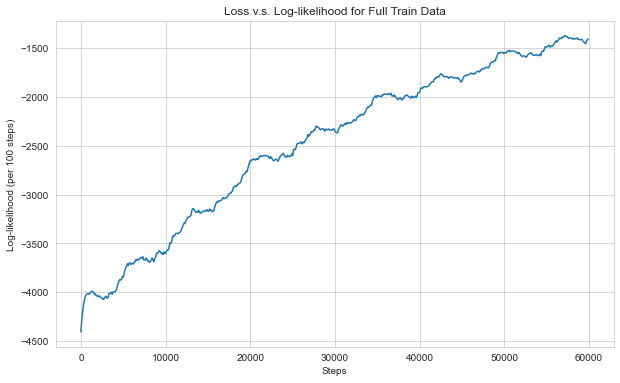

In [259]:
# plot the step v.s. log-likelihood
plt.figure(figsize=(10,6))
ax = sns.lineplot(x = step_list, y = ll_list)
ax.set(xlabel="Steps", ylabel = "Log-likelihood (per 100 steps)")
ax.set_title("Loss v.s. Log-likelihood for Full Train Data")

## Task 2.2: Make prediction on validation dataset

In [16]:
# train the beta
beta = logistic_regression(X = train_mat,
                           y = y_train, 
                           learning_rate = 5e-5, 
                           num_step = 600000)

Starting Logistic Regression to find the parameter vector beta...


100%|████████████████████████████████████████████████████████████████████████| 600000/600000 [01:07<00:00, 8846.57it/s]


In [17]:
# make prediction
y_test = [label_dict[p] for p in dev["party_affiliation"]]
y_pred = []
print("Starting prediction on validation dataset...")
for i in tqdm(range(len(dev))):
    y_pred.append(predict(dev["email_text"][i], beta))

Starting prediction on validation dataset...


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:03<00:00, 5512.45it/s]


In [18]:
# compute f1score
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.8558190242572907

## Task 2.3: Make prediction on test dataset¶

In [19]:
rev_label_dict = {0: 'Democratic Party', 1: 'Republican Party'}

# make prediction
y_pred = []
print("Starting prediction on test dataset...")
for i in tqdm(range(len(test))):
    y_pred.append(predict(test["email_text"][i], beta))
    
result = pd.DataFrame()
result["uid_email"] = test["uid_email"]
result["party_affiliation"] = [rev_label_dict[p] for p in y_pred]

Starting prediction on test dataset...


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:03<00:00, 5534.96it/s]


In [20]:
# output result
result.to_csv("part2_result.csv", index=False)

# Part 3: Logistic Regression with PyTorch

In [48]:
# ignore the installation command if torch has been installed
# ! pip3 install torch torchvision torchaudio
import torch
import torch.nn as nn

In [49]:
def to_sparse_tensor(np_sparse_mat):
    # INPUT: a numpy sprase matrix used previously
    # OUTPUT: a torch sparse matrix
    coo_mat = np_sparse_mat.tocoo()
    
    values = coo_mat.data
    indices = np.vstack((coo_mat.row, coo_mat.col))
    
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo_mat.shape

    torch_sparse_mat = torch.sparse_coo_tensor(i, v, torch.Size(shape))
    return torch_sparse_mat

train_mat_torch = to_sparse_tensor(train_mat)

In [57]:
sig = nn.Sigmoid()
class LogisticRegression(nn.Module):
    def __init__(self, input_features = train_mat_torch.shape[1], output_features = 1, bias=True):
        super().__init__()
        self.layer = nn.Linear(input_features, output_features)
        
    def forward(self, x):
        return sig(self.layer(x))

In [51]:
# useless helper function
def GetTensorRow(tensor, i):
    return tensor.index_select(0, torch.tensor([i % len(tensor)])).to_dense()[0]

In [52]:
# dev data preprocessing for prediction
docs = []
print("Generating doc list for dev ...")
for index, row in tqdm(dev.iterrows(), total = dev.shape[0]):
    docs.append(better_tokenize(row["email_text"]))
    
dev_mat, dev_vocabulary = CSRMatrixGeneration(docs, vocabulary=train_vocabulary)
dev_mat = sparse.hstack([dev_mat, np.zeros(len(dev_mat.toarray()))[:,None]]) # add the missing column
dev_mat = sparse.hstack([dev_mat, np.ones(len(dev_mat.toarray()))[:,None]]) # add the bias column
dev_mat = sparse.csr_matrix(dev_mat)

dev_mat_torch = to_sparse_tensor(dev_mat)

Generating doc list for dev ...


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:02<00:00, 8525.13it/s]


Generating CSR sparse matrix...


100%|█████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 21356.20it/s]


In [69]:
# given a model, predict on the new text
def predict(text, model, vocab_dict = train_vocabulary):
    x_pred = np.zeros(len(vocab_dict) + 1)
    
    term_dict = Counter(better_tokenize(text))
    for term, freq in term_dict.items():
        if term in vocab_dict.keys():
            x_pred[vocab_dict[term]] = freq
    x_pred[-1] = 1 # bias
    
    y_pred = model(torch.tensor(x_pred, dtype=torch.float32))
    if y_pred < 0.5:
        return 0
    else:
        return 1

# given a model, predict on the tensor of new text
def better_predict(x_tensor, model):
    y_pred = model(x_tensor)
    if y_pred < 0.5:
        return 0
    else:
        return 1

In [84]:
# make prediction and get f1 score
dev_mat_torch_dense = dev_mat_torch.to_dense() # set global for quicklier running
def GetF1Score(model, dev = dev):
    y_test = [label_dict[p] for p in dev["party_affiliation"]]
    y_pred = []
    for i in tqdm(range(len(dev))):
        y_pred.append(predict(dev["email_text"][i], model))
    return f1_score(y_test, y_pred) # compute f1score

def better_GetF1Score(model, dev = dev):
    # require dev_mat_torch as global variable
    y_test = [label_dict[p] for p in dev["party_affiliation"]]
    y_pred = []
    for i in range(len(dev_mat_torch)):
        y_pred.append(
            better_predict(dev_mat_torch_dense[i], model)
        )
    return f1_score(y_test, y_pred) # compute f1score

In [151]:
train_mat_torch_dense = train_mat_torch.to_dense()  # set global for quicklier running

def TrainModel(X = train_mat_torch_dense, y = y_train, num_epoch = 1, num_step = len(train_mat_torch), \
               opt_choice = 1, learning_rate = 5e-5, l2penalty = 0, \
               isloss = False, isf1score = False):
    # INPUT: X is a torch sparse matrix
    # INPUT: y is a list or np.array of labels
    # OUTPUT: a LR model with trained parameters
    model = LogisticRegression()
    criterion = nn.BCELoss() # loss function
    if opt_choice == 1: # default optimizer
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2penalty)
    elif opt_choice == 2:
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=l2penalty)
    elif opt_choice == 3:
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2penalty)

    # for plotting
    step_list = []
    if isloss:
        loss_list = []
    if isf1score:
        f1score_list = []

    for epoch in range(num_epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        print(f"Starting training in epoch {epoch + 1}...")
        for i in tqdm(range(num_step)):
            # get the inputs and label
            inputs = X[i]
            labels = torch.tensor(y_train[i], dtype=torch.float32).reshape(1)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i + 1) % 1000 == 0:
                # print(f'epoch = {epoch + 1}, step = {i} => loss: {running_loss / 1000:.3f}')
                step_list.append(epoch * num_step + i)
                if isloss:
                    loss_list.append(running_loss)
                if isf1score:
                    f1score_list.append(better_GetF1Score(model))
                
                running_loss = 0.0
    
    print('Finished Training')
    
    if isloss and isf1score: 
        return model, step_list, loss_list, f1score_list
    elif isloss and not isf1score:
        return model, step_list, loss_list
    else:
        return model

## Task 3.1: Compute loss and F1score for 5 epochs

In [152]:
# train the model
origin_model, step_list, loss_list = TrainModel(num_epoch=5, isloss=True, isf1score=False)

Starting training in epoch 1...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:11<00:00, 5175.57it/s]


Starting training in epoch 2...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:11<00:00, 5232.65it/s]


Starting training in epoch 3...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:11<00:00, 5243.69it/s]


Starting training in epoch 4...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:11<00:00, 5299.46it/s]


Starting training in epoch 5...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:11<00:00, 5312.62it/s]

Finished Training


Text(0.5, 1.0, 'Loss v.s. Step for Default Setting')

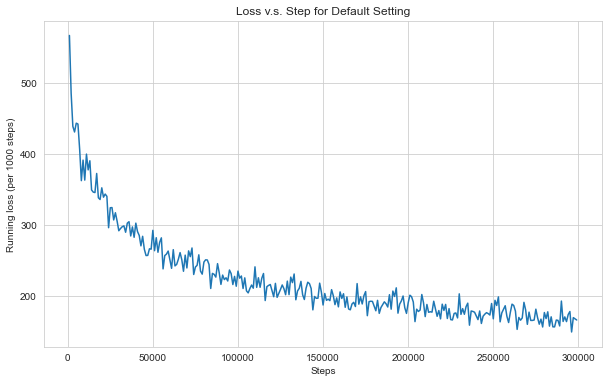

In [175]:
# plot the loss
plt.figure(figsize=(10,6))
ax = sns.lineplot(x = step_list, y = loss_list)
ax.set(xlabel="Steps", ylabel = "Running loss (per 1000 steps)")
ax.set_title("Loss v.s. Step for Default Setting")

In [154]:
# print the f1score
f1score = better_GetF1Score(origin_model)
print(f"The F1score of the model after training for 5 epochs is {f1score}")

The F1score of the model after training for 5 epochs is 0.8266100495399858


## Task 3.2: Compute loss and F1score for L2 penalty variations

In [216]:
l2panelty_model1, step_list1, loss_list1, f1score_list1 = \
    TrainModel(l2penalty = 0, isloss=True, isf1score=True)
l2panelty_model2, step_list2, loss_list2, f1score_list2 = \
    TrainModel(l2penalty = 0.001, isloss=True, isf1score=True)
l2panelty_model3, step_list3, loss_list3, f1score_list3 = \
    TrainModel(l2penalty = 0.1, isloss=True, isf1score=True)

Starting training in epoch 1...


100%|███████████████████████████████████████████████████████████████████████████| 59999/59999 [01:07<00:00, 888.14it/s]


Finished Training
Starting training in epoch 1...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:56<00:00, 1064.91it/s]


Finished Training
Starting training in epoch 1...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:55<00:00, 1073.54it/s]

Finished Training


In [217]:
# create the dataframe
l2panelty_df = pd.DataFrame({
    "step": step_list1 + step_list2 + step_list3,
    "loss": loss_list1 + loss_list2 + loss_list3,
    "f1score": f1score_list1 + f1score_list2 + f1score_list3,
    "label": [0] * len(step_list1) + [0.001] * len(step_list1) + [0.1] * len(step_list3) 
})

Text(0.5, 1.0, 'Loss v.s. Step for L2 Penalty Variation')

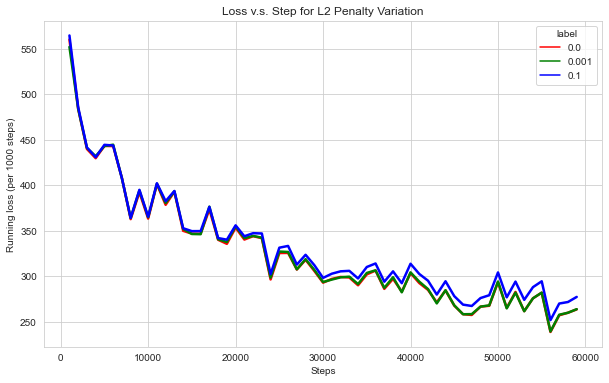

In [218]:
# plot the loss
plt.figure(figsize=(10,6))
ax = sns.lineplot(x="step", y="loss", hue="label", 
                  data=l2panelty_df, palette=['r', 'g', 'b'], linewidth=2.5)
ax.set(xlabel="Steps", ylabel = "Running loss (per 1000 steps)")
ax.set_title("Loss v.s. Step for L2 Penalty Variation")

Text(0.5, 1.0, 'F1score v.s. Step for L2 Penalty Variation')

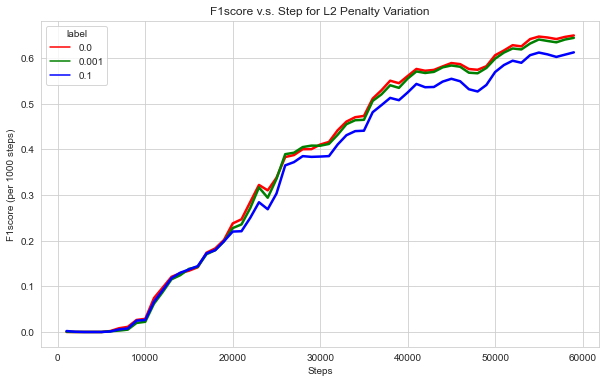

In [219]:
# plot the f1score
plt.figure(figsize=(10,6))
ax = sns.lineplot(x="step", y="f1score", hue="label", 
                  data=l2panelty_df, palette=['r', 'g', 'b'], linewidth=2.5)
ax.set(xlabel="Steps", ylabel = "F1score (per 1000 steps)")
ax.set_title("F1score v.s. Step for L2 Penalty Variation")

## Task 3.3: Compute loss and F1score for optimizer variations

In [221]:
opt_model1, step_list1, loss_list1, f1score_list1 = \
    TrainModel(opt_choice = 1, isloss=True, isf1score=True)
opt_model2, step_list2, loss_list2, f1score_list2 = \
    TrainModel(opt_choice = 2, isloss=True, isf1score=True)
opt_model3, step_list3, loss_list3, f1score_list3 = \
    TrainModel(opt_choice = 3, isloss=True, isf1score=True)

Starting training in epoch 1...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:55<00:00, 1089.42it/s]


Finished Training
Starting training in epoch 1...


100%|███████████████████████████████████████████████████████████████████████████| 59999/59999 [01:01<00:00, 975.68it/s]


Finished Training
Starting training in epoch 1...


100%|███████████████████████████████████████████████████████████████████████████| 59999/59999 [01:05<00:00, 909.55it/s]

Finished Training


In [222]:
# create the dataframe
opt_df = pd.DataFrame({
    "step": step_list1 + step_list2 + step_list3,
    "loss": loss_list1 + loss_list2 + loss_list3,
    "f1score": f1score_list1 + f1score_list2 + f1score_list3,
    "label": ["SGD"] * len(step_list1) + ["RMSprop"] * len(step_list1) + ["AdamW"] * len(step_list3) 
})

Text(0.5, 1.0, 'Loss v.s. Step for Optimizer Variation')

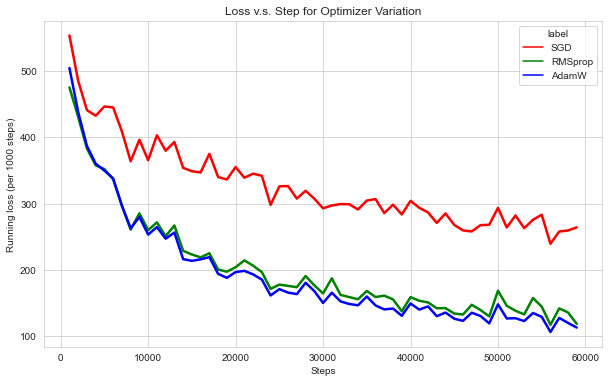

In [223]:
# plot the loss
plt.figure(figsize=(10,6))
ax = sns.lineplot(x="step", y="loss", hue="label", 
                  data=opt_df, palette=['r', 'g', 'b'], linewidth=2.5)
ax.set(xlabel="Steps", ylabel = "Running loss (per 1000 steps)")
ax.set_title("Loss v.s. Step for Optimizer Variation")

Text(0.5, 1.0, 'F1score v.s. Step for Optimizer Variation')

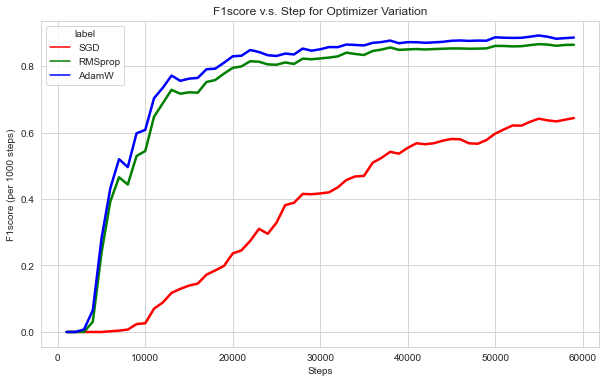

In [224]:
# plot the f1score
plt.figure(figsize=(10,6))
ax = sns.lineplot(x="step", y="f1score", hue="label", 
                  data=opt_df, palette=['r', 'g', 'b'], linewidth=2.5)
ax.set(xlabel="Steps", ylabel = "F1score (per 1000 steps)")
ax.set_title("F1score v.s. Step for Optimizer Variation")

## Task 3.4: Compute loss and F1score for tokenization variations

In [189]:
# See additional file tokenize_variation.ipynb for this task
# the data for tokenize is from the result of tokenize_variation.ipynb
tokenize_model2, step_list2, loss_list2, f1score_list2 = TrainModel(isloss=True, isf1score=True)

Starting training in epoch 1...


100%|███████████████████████████████████████████████████████████████████████████| 59999/59999 [04:02<00:00, 247.25it/s]

Finished Training


In [202]:
# create the dataframe
tokenize_data_df1 = pd.read_csv("tokenize_data.csv")
tokenize_data_df2 = pd.DataFrame({
    "step": step_list2,
    "loss": loss_list2,
    "f1score": f1score_list2,
    "label": "Better"
})
tokenize_df = pd.concat([tokenize_data_df1, tokenize_data_df2]).reset_index()

In [203]:
tokenize_df

,index,step,loss,f1score,label
0,0,999,469.008717,0.024181,Worse
1,1,1999,453.849513,0.056414,Worse
2,2,2999,418.691492,0.270742,Worse
3,3,3999,402.939529,0.233068,Worse
4,4,4999,405.533156,0.340738,Worse
...,...,...,...,...,...
113,54,54999,282.001152,0.642568,Better
114,55,55999,238.184220,0.638738,Better
115,56,56999,255.789351,0.634910,Better
116,57,57999,259.756308,0.641624,Better


Text(0.5, 1.0, 'Loss v.s. Step for Tokenize Variation')

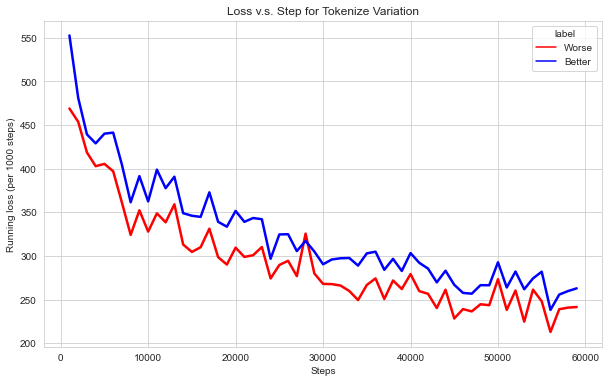

In [204]:
# plot the loss
plt.figure(figsize=(10,6))
ax = sns.lineplot(x="step", y="loss", hue="label", 
                  data=tokenize_df, palette=['r', 'b'], linewidth=2.5)
ax.set(xlabel="Steps", ylabel = "Running loss (per 1000 steps)")
ax.set_title("Loss v.s. Step for Tokenize Variation")

Text(0.5, 1.0, 'F1score v.s. Step for Tokenize Variation')

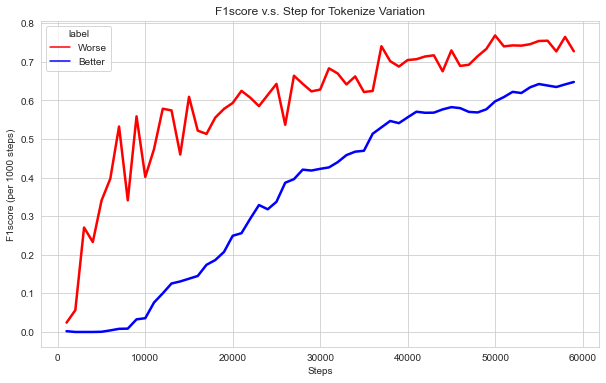

In [205]:
# plot the f1score
plt.figure(figsize=(10,6))
ax = sns.lineplot(x="step", y="f1score", hue="label", 
                  data=tokenize_df, palette=['r',  'b'], linewidth=2.5)
ax.set(xlabel="Steps", ylabel = "F1score (per 1000 steps)")
ax.set_title("F1score v.s. Step for Tokenize Variation")

## Task 3.5: Compute loss and F1score for learning rate variations

In [262]:
lr_model1, step_list1, loss_list1, f1score_list1 = \
    TrainModel(learning_rate=5e-2, isloss=True, isf1score=True)
lr_model2, step_list2, loss_list2, f1score_list2 = \
    TrainModel(learning_rate=5e-5, isloss=True, isf1score=True)
lr_model3, step_list3, loss_list3, f1score_list3 = \
    TrainModel(learning_rate=5e-8, isloss=True, isf1score=True)

Starting training in epoch 1...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:57<00:00, 1039.99it/s]


Finished Training
Starting training in epoch 1...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:53<00:00, 1126.84it/s]


Finished Training
Starting training in epoch 1...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:52<00:00, 1134.14it/s]

Finished Training


In [263]:
# create the dataframe
lr_df = pd.DataFrame({
    "step": step_list1 + step_list2 + step_list3,
    "loss": loss_list1 + loss_list2 + loss_list3,
    "f1score": f1score_list1 + f1score_list2 + f1score_list3,
    "label": ["5e-2"] * len(step_list1) + ["5e-5"] * len(step_list1) + ["5e-8"] * len(step_list3) 
})

Text(0.5, 1.0, 'Loss v.s. Step for Learning Rate Variation')

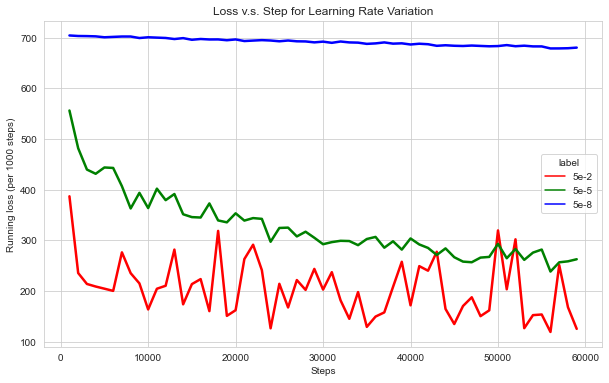

In [264]:
# plot the loss
plt.figure(figsize=(10,6))
ax = sns.lineplot(x="step", y="loss", hue="label", 
                  data=lr_df, palette=['r', 'g', 'b'], linewidth=2.5)
ax.set(xlabel="Steps", ylabel = "Running loss (per 1000 steps)")
ax.set_title("Loss v.s. Step for Learning Rate Variation")

Text(0.5, 1.0, 'F1score v.s. Step for Learning Rate Variation')

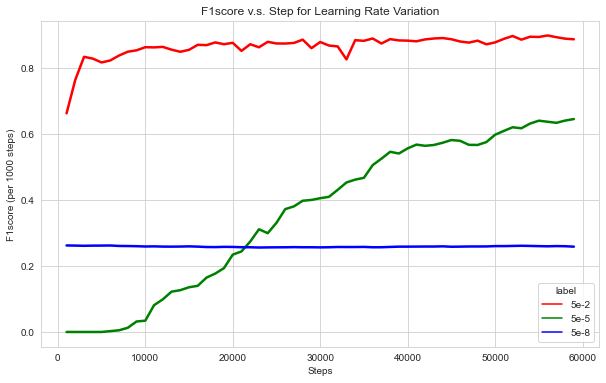

In [265]:
# plot the f1score
plt.figure(figsize=(10,6))
ax = sns.lineplot(x="step", y="f1score", hue="label", 
                  data=lr_df, palette=['r', 'g', 'b'], linewidth=2.5)
ax.set(xlabel="Steps", ylabel = "F1score (per 1000 steps)")
ax.set_title("F1score v.s. Step for Learning Rate Variation")

## Task 3.6: Make prediction on test dataset

In [229]:
# train the best model
best_model = TrainModel(num_epoch = 20, 
                        opt_choice = 3, 
                        learning_rate = 5e-5, 
                        l2penalty = 0)

Starting training in epoch 1...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:23<00:00, 2588.79it/s]


Starting training in epoch 2...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:23<00:00, 2595.40it/s]


Starting training in epoch 3...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:23<00:00, 2594.24it/s]


Starting training in epoch 4...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:23<00:00, 2592.63it/s]


Starting training in epoch 5...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:23<00:00, 2588.34it/s]


Starting training in epoch 6...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:23<00:00, 2607.99it/s]


Starting training in epoch 7...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:23<00:00, 2607.89it/s]


Starting training in epoch 8...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:23<00:00, 2596.89it/s]


Starting training in epoch 9...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:23<00:00, 2605.17it/s]


Starting training in epoch 10...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:23<00:00, 2571.40it/s]


Starting training in epoch 11...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:23<00:00, 2555.26it/s]


Starting training in epoch 12...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:23<00:00, 2525.86it/s]


Starting training in epoch 13...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:23<00:00, 2540.23it/s]


Starting training in epoch 14...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:23<00:00, 2557.13it/s]


Starting training in epoch 15...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:23<00:00, 2553.57it/s]


Starting training in epoch 16...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:23<00:00, 2568.75it/s]


Starting training in epoch 17...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:23<00:00, 2552.09it/s]


Starting training in epoch 18...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:23<00:00, 2539.77it/s]


Starting training in epoch 19...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:23<00:00, 2561.11it/s]


Starting training in epoch 20...


100%|██████████████████████████████████████████████████████████████████████████| 59999/59999 [00:23<00:00, 2540.25it/s]

Finished Training


In [230]:
f1score = better_GetF1Score(best_model)
print(f"The F1score of the best model after training for 5 epochs is {f1score}")

The F1score of the best model after training for 5 epochs is 0.9259452411994785


In [231]:
# test data preprocessing for prediction
docs = []
print("Generating doc list for test ...")
for index, row in tqdm(test.iterrows(), total = test.shape[0]):
    docs.append(better_tokenize(row["email_text"]))
    
test_mat, test_vocabulary = CSRMatrixGeneration(docs, vocabulary=train_vocabulary)
test_mat = sparse.hstack([test_mat, np.ones(len(dev_mat.toarray()))[:,None]]) # add the bias column
test_mat = sparse.csr_matrix(test_mat)

test_mat_torch = to_sparse_tensor(test_mat)
test_mat_torch_dense = test_mat_torch.to_dense()

Generating doc list for test ...


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:02<00:00, 8512.48it/s]


Generating CSR sparse matrix...


100%|█████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 20969.51it/s]


In [232]:
rev_label_dict = {0: 'Democratic Party', 1: 'Republican Party'}

# make prediction
y_pred = []
print("Starting prediction on test dataset...")
for i in tqdm(range(len(test_mat_torch_dense))):
    y_pred.append(better_predict(test_mat_torch_dense[i], best_model))
    
result = pd.DataFrame()
result["uid_email"] = test["uid_email"]
result["party_affiliation"] = [rev_label_dict[p] for p in y_pred]

# output result
result.to_csv("part3_result.csv", index=False)

Starting prediction on test dataset...


100%|█████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 26043.37it/s]
